# Reading in data

In [286]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define constants
DATA_DIR = r'C:\Mini_Project\output\20251119\data'
STRIKES = [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2]
MATURITIES = [30, 60, 90, 120, 150, 180, 360]
START_DATE = datetime(2015, 11, 2)
END_DATE = datetime(2026, 12, 31)
DAYS_IN_YEAR = 252
# Generate the list of dates in the range (closed interval)
all_dates = pd.date_range(START_DATE, END_DATE, freq='B')  # Use business days if needed, else use 'D'


In [287]:
import re

data_dir = r'C:\Mini_Project\output\20251119\data'
real_data_dir = os.path.join(data_dir, "real_data")

prices_file = os.path.join(real_data_dir, "option_prices.csv")

prices_df = pd.read_csv(prices_file, parse_dates=True)
prices_df.set_index('Unnamed: 0', inplace=True)

pattern = r"strike_([0-9\.]+)_maturity_([0-9]+)"

records = []
for col in prices_df.columns:
    match = re.match(pattern, col)
    if match:
        strike = float(match.group(1))
        maturity_days = int(match.group(2))
        maturity_years = maturity_days / 365.0

        for idx, row in prices_df.loc[:, [col]].iterrows():
            date = idx
            option_price = row.values[0]

            records.append({
                'date': date,
                'relative_strike': strike,
                'maturity_days': maturity_days,
                'maturity_years': maturity_years,
                'option_price': option_price
            })

prices_df_long = pd.DataFrame(records)

import glob

# The yearly data folders are located under DATA_DIR, one per year
yearly_folders = sorted([f for f in glob.glob(os.path.join(DATA_DIR, '*')) if os.path.isdir(f) and re.match(r'.*(20\d{2})$', f)])
all_year_prices = []

for folder in yearly_folders:
    # Extract year from folder name assuming it ends with the year YYYY
    year_match = re.search(r'(20\d{2})$', folder)
    if not year_match:
        continue
    year = year_match.group(1)
    price_file = os.path.join(folder, f"^NDX_options_data_{year}.csv")
    yearly_df = pd.read_csv(price_file)
    if 'date' in yearly_df.columns:
        yearly_df['date'] = pd.to_datetime(yearly_df['date'])
    all_year_prices.append(yearly_df)

if all_year_prices:
    # Combine all yearly dataframes into one
    all_prices_df = pd.concat(all_year_prices, ignore_index=True)
else:
    all_prices_df = pd.DataFrame()
# Ensure date types are compatible for merging
prices_df_long['date'] = pd.to_datetime(prices_df_long['date'])

# Merge in current_price from the yearly data files (require 'date', 'strike', 'maturity_days', 'current_price')
prices_df_long = prices_df_long.merge(
    all_prices_df[['date', 'relative_strike','strike', 'maturity_days', 'current_price']],
    on=['date', 'relative_strike', 'maturity_days'],
    how='left'
)


In [288]:
def load_RFR_data(data_dir, start_date, end_date):

    all_rfr_data = pd.read_csv(os.path.join(data_dir, "EFFR.csv"))
    all_rfr_data.ffill(inplace=True)
    all_rfr_data['EFFR'] = (all_rfr_data['EFFR'] / 100).astype(float) # percentage to decimal
    all_rfr_data['observation_date'] = pd.to_datetime(all_rfr_data['observation_date'])
    all_rfr_data.set_index('observation_date', inplace=True)
    rfr_data = all_rfr_data.loc[(all_rfr_data.index >= pd.to_datetime(START_DATE)) & (all_rfr_data.index <= pd.to_datetime(END_DATE))]
    return rfr_data


rfr_path = os.path.join(DATA_DIR, '../../../raw_data')
rfr_data = load_RFR_data(rfr_path, START_DATE, END_DATE)


In [289]:
options_data = prices_df_long.merge(rfr_data, left_on='date', right_index=True, how='left')
options_data.tail()

,date,relative_strike,maturity_days,maturity_years,option_price,strike,current_price,EFFR
47623,2018-10-25,1.2,360,0.986301,217.900260,8425.0,7016.390137,0.022
47624,2018-10-26,1.2,360,0.986301,155.950385,8225.0,6852.399902,0.022
47625,2018-10-29,1.2,360,0.986301,190.362606,8050.0,6713.899902,0.022
47626,2018-10-30,1.2,360,0.986301,270.044728,8175.0,6810.120117,0.022
47627,2018-10-31,1.2,360,0.986301,243.716647,8350.0,6967.100098,0.022


## Pricing functions
Take from https://www.codearmo.com/python-tutorial/merton-jump-diffusion-model-python
based on 

$$V_{MJD}(S,K,T,r,\sigma, m,v, \lambda) = \sum_{k=0}^{\infty} \dfrac{\exp(-m \lambda T) (m \lambda T)^k}{k!} V_{BS} (S,K,T,r_n, \sigma_k)$$

where conditioned on $k$ jumps:

$$\sigma_k = \sqrt{\sigma^2 + k \frac{v^2}{T} r_k} = r - \lambda(m-1) + \dfrac{k \log (m)}{T}$$

In [290]:
import numpy as np
from scipy.stats import norm
from scipy.special import factorial
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    

def merton_jump_call(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Merton jump-diffusion call option price using standard parameterization.
    
    Parameters:
    -----------
    mu_J : float
        Mean of log jump size (μ_J)
    sigma_J : float
        Std of log jump size (σ_J)
    """
    p = 0
    # Calculate E[Y] = exp(μ_J + σ_J²/2) and k = E[Y - 1]
    E_Y = np.exp(mu_J + sigma_J**2 / 2)
    k = E_Y - 1
    
    for n in range(40):  # n = number of jumps
        # Adjusted risk-free rate for n jumps: r_n = r - λk + (n * μ_J) / T
        r_n = r - lam * k + (n * mu_J) / T
        
        # Adjusted volatility for n jumps: σ_n = sqrt(σ² + n * σ_J² / T)
        sigma_n = np.sqrt(sigma**2 + (n * sigma_J**2) / T)
        
        # Poisson probability: P(n jumps) = exp(-λT) * (λT)^n / n!
        n_fact = factorial(n)
        poisson_prob = np.exp(-lam * T) * (lam * T)**n / n_fact
        
        # Black-Scholes price conditioned on n jumps
        bs_price = BS_CALL(S, K, T, r_n, sigma_n)
        p += poisson_prob * bs_price
    
    return p

def merton_jump_put(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Merton jump-diffusion put option price using standard parameterization.
    
    Parameters:
    -----------
    mu_J : float
        Mean of log jump size (μ_J)
    sigma_J : float
        Std of log jump size (σ_J)
    """
    p = 0
    # Calculate E[Y] = exp(μ_J + σ_J²/2) and k = E[Y - 1]
    E_Y = np.exp(mu_J + sigma_J**2 / 2)
    k = E_Y - 1
    
    for n in range(40):  # n = number of jumps
        # Adjusted risk-free rate for n jumps: r_n = r - λk + (n * μ_J) / T
        r_n = r - lam * k + (n * mu_J) / T
        
        # Adjusted volatility for n jumps: σ_n = sqrt(σ² + n * σ_J² / T)
        sigma_n = np.sqrt(sigma**2 + (n * sigma_J**2) / T)
        
        # Poisson probability: P(n jumps) = exp(-λT) * (λT)^n / n!
        n_fact = factorial(n)
        poisson_prob = np.exp(-lam * T) * (lam * T)**n / n_fact
        
        # Black-Scholes price conditioned on n jumps
        bs_price = BS_PUT(S, K, T, r_n, sigma_n)
        p += poisson_prob * bs_price
    
    return p 

In [291]:
from scipy.optimize import minimize
import json

def optimal_params(x, mkt_prices, strikes, option_types):
    """
    Objective function for parameter calibration.
    
    Parameters:
    -----------
    x : array
        [sigma, mu_J, sigma_J, lam]
        - sigma: volatility
        - mu_J: mean of log jump size (μ_J)
        - sigma_J: std of log jump size (σ_J)
        - lam: jump intensity (λ)
    """
    # Vectorize the pricing function over strikes, using appropriate function based on option type
    candidate_prices = []
    for K, opt_type in zip(strikes, option_types):
        if opt_type.lower() == 'call':
            price = merton_jump_call(S, K, T, r, sigma=x[0], mu_J=x[1], sigma_J=x[2], lam=x[3])
        else:  # put
            price = merton_jump_put(S, K, T, r, sigma=x[0], mu_J=x[1], sigma_J=x[2], lam=x[3])
        candidate_prices.append(price)
    candidate_prices = np.array(candidate_prices)
    return np.linalg.norm(mkt_prices - candidate_prices, 2)

# Loop over unique Mondays in 'date' column of options_data
jump_params = {}

# Ensure 'date' column is datetime
options_data['date'] = pd.to_datetime(options_data['date'])

# Get unique Mondays present in data
mondays = options_data[options_data['date'].dt.weekday == 0]['date'].dt.strftime('%Y-%m-%d').unique()

for date in mondays:
    print(f"Processing date: {date}")
    single_option_ts = options_data[options_data['date'] == pd.to_datetime(date)]
    single_option_ts = single_option_ts.reset_index(drop=True)

    if single_option_ts.empty:
        continue  # skip if there is no data for this date

    T = single_option_ts.iloc[0].maturity_years
    S = single_option_ts.iloc[0].current_price
    r = single_option_ts.iloc[0].EFFR

    # Construct option_type based on strike vs spot price
    # If K > S, then 'call', otherwise 'put'
    single_option_ts['option_type'] = single_option_ts['strike'].apply(
        lambda K: 'call' if K > S else 'put'
    )

    # Initial guess: [sigma, mu_J, sigma_J, lam]
    # sigma: volatility (typically 0.1-0.3)
    # mu_J: mean of log jump size (can be negative for downward jumps, typically -0.1 to 0.1)
    # sigma_J: std of log jump size (typically 0.1-0.5)
    # lam: jump intensity (typically 0.5-5)
    x0 = [0.15, -0.05, 0.2, 1.5]  # initial guess for algorithm

    # Bounds:
    # vol: 0.01 < sigma < 2 
    # mu_J: mean of log jump size (can be negative, typically -1 to 1)
    # sigma_J: std of log jump size (0.01 < sigma_J < 2)
    # intensity: 0 < lam < 20
    bounds = ((0.01, 2), (-1.0, 1.0), (0.01, 2), (0, 20))
    strikes = single_option_ts['strike'].values
    prices = single_option_ts['option_price'].values
    option_types = single_option_ts['option_type'].values

    res = minimize(optimal_params, method='SLSQP', x0=x0, args=(prices, strikes, option_types),
                   bounds=bounds, tol=1e-2,
                   options={"maxiter": 100, "disp": True})
    sigt = res.x[0]
    mu_J = res.x[1]  # Mean of log jump size
    sigma_J = res.x[2]  # Std of log jump size
    lamt = res.x[3]

    jump_params[date] = {
        'spot_price': S,
        'risk_free_rate': r,
        'time_to_maturity': T,
        'volatility': sigt,
        'jump_mean': mu_J,  # Now represents μ_J (mean of log jump size)
        'jump_std': sigma_J,  # Now represents sigma_J (std of log jump size)
        'jump_intensity': lamt
    }

    # Calculate E[Y] for reference
    E_Y = np.exp(mu_J + sigma_J**2 / 2)
    k = E_Y - 1
    
    print(f"    Final objective value: {res.fun}, Number of iterations: {res.nit}")
    print(f"    Calibrated: sigma={sigt:.6f}, μ_J={mu_J:.6f}, sigma_J={sigma_J:.6f}, λ={lamt:.6f}")
    print(f"    Derived: E[Y]={E_Y:.6f}, k=E[Y-1]={k:.6f}")
    with open("jump_process_params.log", "w") as f:
        json.dump(jump_params[date], f, indent=4, default=str)
    print("    Jump process parameters written to jump_process_params.log.")


Processing date: 2015-11-02
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2045.128733297205
            Iterations: 25
            Function evaluations: 142
            Gradient evaluations: 25
    Final objective value: 2045.128733297205, Number of iterations: 25
    Calibrated: sigma=0.010000, μ_J=-1.000000, sigma_J=1.393338, λ=0.830429
    Derived: E[Y]=0.971120, k=E[Y-1]=-0.028880
    Jump process parameters written to jump_process_params.log.
Processing date: 2015-11-09
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1987.5455803452455
            Iterations: 26
            Function evaluations: 146
            Gradient evaluations: 26
    Final objective value: 1987.5455803452455, Number of iterations: 26
    Calibrated: sigma=0.010000, μ_J=-1.000000, sigma_J=1.378397, λ=0.798906
    Derived: E[Y]=0.951220, k=E[Y-1]=-0.048780
    Jump process parameters written to jump_process_params.log.
Proces

In [294]:
import json
# Write jump_params as a log to jump_process_params.log
with open("jump_process_params.log", "w") as f:
    json.dump(jump_params, f, indent=4, default=str)
print("    Jump process parameters written to jump_process_params.log.")



    Jump process parameters written to jump_process_params.log.


In [295]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import numpy as np

# def merton_jump_paths(S_array, T, r, sigma,  lam, m, v, steps, Npaths):
#     # Validate inputs
#     if steps <= 0:
#         raise ValueError(f"steps must be positive, got {steps}")
#     if T <= 0:
#         raise ValueError(f"T must be positive, got {T}")
    
#     # Convert S_array to numpy array and validate shape
#     S_array = np.asarray(S_array)
#     if S_array.ndim != 1:
#         raise ValueError(f"S_array must be 1D, got shape {S_array.shape}")
#     if len(S_array) != Npaths:
#         raise ValueError(f"S_array length ({len(S_array)}) must match Npaths ({Npaths})")
    
#     size=(steps,Npaths)
#     dt = T/steps 
    
#     # Cap lam*dt to prevent Poisson overflow (NumPy Poisson has practical limit around 1e6)
#     # Use a reasonable cap of 50
#     lam_dt = lam * dt
#     if lam_dt > 50:
#         print(f"Warning: lam*dt={lam_dt:.2f} is too large, capping to 50")
#         lam_dt = 50
    
#     poi_rv = np.multiply(np.random.poisson(lam_dt, size=size),
#                          np.random.normal(m, v, size=size)).cumsum(axis=0)
#     geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
#                       sigma*np.sqrt(dt) * \
#                       np.random.normal(size=size)), axis=0)
    
    # Broadcast S_array to match the shape of exp(geo+poi_rv) which is (steps, Npaths)
    # S_array has shape (Npaths,), so we need to add a new axis to broadcast correctly
    # return np.exp(geo+poi_rv) * S_array[np.newaxis, :]

def merton_jump_paths(S_array, T, r, sigma, lam, m, v, steps, Npaths):
    """
    Simulate Merton jump-diffusion paths following the discrete formulation.
    
    Parameters:
    -----------
    S_array : array-like, shape (Npaths,)
        Initial stock prices for each path
    T : float
        Total time (in years)
    r : float
        Risk-free rate
    sigma : float
        Volatility
    lam : float
        Jump intensity (lambda)
    m : float
        Mean of log jump size (mu_J)
    v : float
        Std of log jump size (sigma_J)
    steps : int
        Number of time steps
    Npaths : int
        Number of paths to simulate
    
    Returns:
    --------
    paths : ndarray, shape (steps, Npaths)
        Simulated stock price paths
    """
    # Validate inputs
    if steps <= 0:
        raise ValueError(f"steps must be positive, got {steps}")
    if T <= 0:
        raise ValueError(f"T must be positive, got {T}")
    
    # Convert S_array to numpy array and validate shape
    S_array = np.asarray(S_array)
    if S_array.ndim != 1:
        raise ValueError(f"S_array must be 1D, got shape {S_array.shape}")
    if len(S_array) != Npaths:
        raise ValueError(f"S_array length ({len(S_array)}) must match Npaths ({Npaths})")
    
    dt = T / steps
    
    # Cap lam*dt to prevent Poisson overflow
    lam_dt = lam * dt
    if lam_dt > 50:
        print(f"Warning: lam*dt={lam_dt:.2f} is too large, capping to 50")
        lam_dt = 50
    
    # Initialize log-prices: L_0 = log(S_0)
    log_prices = np.log(S_array).reshape(1, -1)  # Shape: (1, Npaths)
    
   
    # For now, let's use m as μ_J (mean of log jump size) as per the mathematical formulation:
    mu_J = m  # Mean of log jump size (μ_J)
    sigma_J = v  # Std of log jump size (σ_J)
    
    # Calculate E[Y] = exp(μ_J + σ_J²/2) and k = E[Y - 1]
    E_Y = np.exp(mu_J + sigma_J**2 / 2)
    k = E_Y - 1
    
   
    # Pre-allocate arrays for efficiency
    paths_log = np.zeros((steps, Npaths))
    
    # Simulate step by step
    for k_step in range(steps):
        # Current log-price
        L_tk = log_prices[-1, :]  # Shape: (Npaths,)
        
        # Step 1: Draw standard normal shock
        epsilon = np.random.normal(0, 1, size=(Npaths,))
        dW = np.sqrt(dt) * epsilon
        
        # Step 2: Draw number of jumps
        N_jumps = np.random.poisson(lam_dt, size=(Npaths,))
        
        # Step 3: Calculate jump contribution J_{k+1}
        J = np.zeros(Npaths)
        for path_idx in range(Npaths):
            if N_jumps[path_idx] > 0:
                # Draw log jump sizes: log Y_{k+1,j} ~ N(μ_J, σ_J²)
                log_jump_sizes = np.random.normal(mu_J, v, size=N_jumps[path_idx])
                # Sum them: J_{k+1} = sum of log jump sizes
                J[path_idx] = np.sum(log_jump_sizes)
        
        # Step 4: Update log-price using discrete Merton formula
        # L_{t_{k+1}} = L_{t_k} + (r - λk - ½σ²)Δt + σ√Δt ε_{k+1} + J_{k+1}
        # 
        # Use the formula exactly as written in the mathematical formulation.
        # The drift term -λk where k = E[Y - 1] is designed to ensure the expected
        # price return is r (risk-neutral measure). This formula should work correctly
        # when parameters are interpreted consistently.
        drift = (r - lam * k - 0.5 * sigma**2) * dt
        diffusion = sigma * dW
        L_tk_plus_1 = L_tk + drift + diffusion + J
        
        # Store and update
        paths_log[k_step, :] = L_tk_plus_1
        log_prices = np.vstack([log_prices, L_tk_plus_1.reshape(1, -1)])
    
    # Convert log-prices to prices: S_{t_{k+1}} = exp(L_{t_{k+1}})
    paths = np.exp(paths_log)
    
    return paths


In [322]:
# Simulate Merton jump paths for all dates in options_data
# Use the most recent parameters from jump_params for each date

# Get all unique dates from options_data, sorted
all_dates_in_data = sorted(options_data['date'].unique())
all_dates_in_data = pd.to_datetime(all_dates_in_data)
SEED = 100
np.random.seed(SEED)
# Convert jump_params keys to datetime for comparison
jump_params_dates = sorted([pd.to_datetime(date) for date in jump_params.keys()])

# Parameters for simulation
steps = 360  # Number of time steps (e.g., daily for 1 year)
Npaths = 100000 # Number of paths to simulate
dt = 1/DAYS_IN_YEAR  # Time step (1 day, assuming 252 trading days per year)

# Store simulated paths
simulated_paths = {}

print(f"Simulating Merton jump paths for {len(all_dates_in_data)} dates...")
print(f"Using parameters from {len(jump_params_dates)} calibration dates")

start_date = all_dates_in_data[0]

for current_date_str, params in jump_params.items():
    current_date = pd.to_datetime(current_date_str)  # Convert string to Timestamp
    # print(current_date)
    
    if current_date == start_date:
        S_array = np.full(Npaths, params['spot_price'])
    else:
        S_array = simulated_paths[prev_date]['paths'][-1, :]

    future_params_dates = [d for d in jump_params_dates if d > current_date]
    
    next_param_date = min(future_params_dates) if future_params_dates else None
    if next_param_date is not None:
        n_days = (next_param_date - current_date).days
    else:
        # Last interval: simulate until the last date in options_data
        n_days = (max(all_dates_in_data) - current_date).days

    r = params['risk_free_rate']
    sigma = params['volatility']
    lam = params['jump_intensity']
    m = params['jump_mean']
    v = params['jump_std']
    
    # Calculate T based on the actual interval length (in years)
    T = n_days / DAYS_IN_YEAR
    n_steps = max(1, n_days)  # Ensure at least 1 step
    
    # Simulate paths
    try:
        paths = merton_jump_paths(S_array, T, r, sigma, lam, m, v, n_steps, Npaths)
    except (ValueError, Exception) as e:
        print(f"    Error simulating {current_date_str}: {e}")
        print(f"    Parameters: T={T:.4f}, n_steps={n_steps}, lam={lam:.4f}, lam*dt={lam*T/n_steps:.4f}")
        continue
    
    # Store the simulated paths
    simulated_paths[current_date_str] = {
        'paths': paths,
        'parameters_date': current_date_str,
        'parameters': params
    }
    prev_date = current_date_str

print(f"Completed simulation for {len(simulated_paths)} dates")


Simulating Merton jump paths for 756 dates...
Using parameters from 140 calibration dates
Completed simulation for 140 dates


In [298]:
# We want to assemble the simulated paths into a (252, Npaths) array, filling days in order.
# We'll fill each interval's simulated paths into their respective positions.

# First, create a sorted list of all simulation dates
all_sim_dates = sorted(simulated_paths.keys())
Npaths = None
filled_days = 0

# Determine total simulation days (we use 252 as the conventional "year" length)
TOTAL_SIM_DAYS = 252 * 3

for v in simulated_paths.values():
    Npaths = v['paths'].shape[1]
    break
sim_records = np.full((TOTAL_SIM_DAYS, Npaths), np.nan)


cur_row = 0
for idx, date_str in enumerate(all_sim_dates):
    paths = simulated_paths[date_str]['paths']  # shape: (n_steps, Npaths)
    n_steps = paths.shape[0]

    # Place in sim_records[cur_row : cur_row+n_steps, :]
    end_row = min(cur_row + n_steps, TOTAL_SIM_DAYS)
    rows_to_copy = end_row - cur_row
    sim_records[cur_row:end_row, :] = paths[:rows_to_copy, :]
    cur_row += rows_to_copy
    if cur_row >= TOTAL_SIM_DAYS:
        break  # filled up

print(f"Shape of sim_records: {sim_records.shape}")
sim_paths_df = pd.DataFrame(sim_records)


Shape of sim_records: (756, 1000)


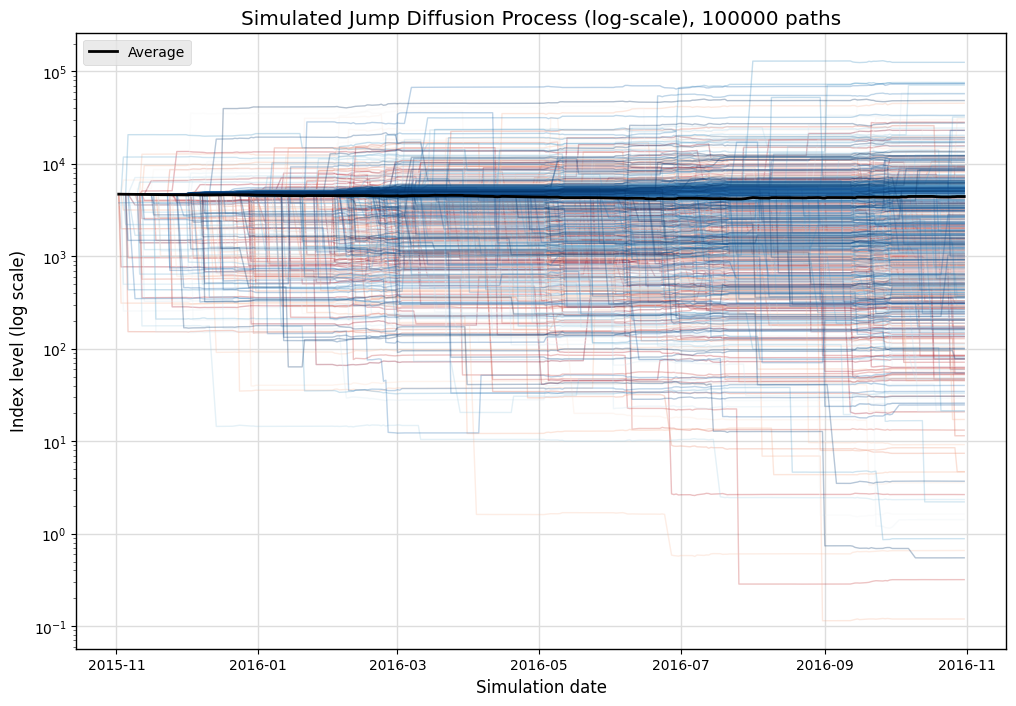

In [341]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all simulated paths with low alpha, using RdBu colormap
# Set background white and axes/edges black
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Add major x and y grid lines in light gray
ax.grid(which='major', color='#dddddd', linestyle='-', linewidth=1, axis='both')

num_paths = sim_paths_df.shape[1]
colors = plt.cm.RdBu(np.linspace(0, 1, num_paths))
for i in range(num_paths):
    ax.plot(sim_paths_df.iloc[:252, i], color=colors[i], alpha=0.3, linewidth=1)

# Plot the mean path as a solid black line
mean_path = sim_paths_df.iloc[:252, :].mean(axis=1)
ax.plot(mean_path, color='black', linewidth=2, label='Average')

ax.set_xlabel('Simulation date', color='black')
ax.set_ylabel('Index level (log scale)', color='black')
ax.set_title(f'Simulated Jump Diffusion Process (log-scale), {Npaths} paths', color='black')
ax.set_yscale('log')
ax.tick_params(colors='black')
ax.legend()
plt.show()

In [327]:
r_df = options_data.loc[:, ['date', 'EFFR']].drop_duplicates()
display(r_df)

,date,EFFR
0,2015-11-02,0.0012
1,2015-11-03,0.0012
2,2015-11-04,0.0012
3,2015-11-05,0.0012
4,2015-11-06,0.0012
...,...,...
751,2018-10-25,0.0220
752,2018-10-26,0.0220
753,2018-10-29,0.0220
754,2018-10-30,0.0220


In [328]:
# We'll compute the European call option price for each day using the risk-neutral expectation over simulated terminal prices

# Parameters for option pricing (choose a reference strike and risk-free rate)
# Use strike as the mean of the first day's simulated prices for example
strike = sim_paths_df.iloc[0].mean()
T = TOTAL_SIM_DAYS / DAYS_IN_YEAR  # total maturity in years (1 year)




In [329]:
options_data['option_type'] = options_data.apply(lambda x: 'call' if x.strike > x.current_price else 'put', axis = 1)
sim_paths_df.index = sorted(options_data['date'].unique().tolist())[:TOTAL_SIM_DAYS]
date_list = sorted(options_data['date'].unique().tolist())

options_data

,date,relative_strike,maturity_days,maturity_years,option_price,strike,current_price,EFFR,option_type,simulated_price
0,2015-11-02,0.8,30,0.082192,941.946280,3775.0,4703.919922,0.0012,put,180.629500
1,2015-11-03,0.8,30,0.082192,945.216501,3775.0,4719.049805,0.0012,put,188.880887
2,2015-11-04,0.8,30,0.082192,945.734158,3775.0,4717.549805,0.0012,put,203.469786
3,2015-11-05,0.8,30,0.082192,942.932446,3750.0,4702.899902,0.0012,put,206.000653
4,2015-11-06,0.8,30,0.082192,942.011448,3775.0,4707.229980,0.0012,put,210.906887
...,...,...,...,...,...,...,...,...,...,...
47623,2018-10-25,1.2,360,0.986301,217.900260,8425.0,7016.390137,0.0220,call,NaN
47624,2018-10-26,1.2,360,0.986301,155.950385,8225.0,6852.399902,0.0220,call,NaN
47625,2018-10-29,1.2,360,0.986301,190.362606,8050.0,6713.899902,0.0220,call,NaN
47626,2018-10-30,1.2,360,0.986301,270.044728,8175.0,6810.120117,0.0220,call,NaN


In [330]:

prices = []
for _, row in options_data.iterrows():
    date = row['date']
    date_idx = date_list.index(date)
    option_type = row['option_type']
    strike = row['strike']
    maturity_days = row['maturity_days']
    maturity_years = maturity_years
    strike = row['strike']
    
    if date_idx + maturity_days > TOTAL_SIM_DAYS:
        prices.append(np.nan)
        continue
    
    # Check if expiry date index is within bounds of date_list
    try:
        if date_idx + maturity_days >= len(date_list):
            prices.append(np.nan)
            continue
        expiry_date = date_list[date_idx + maturity_days]
        expiry_idx = date_list.index(expiry_date)

        # Time to maturity in years
        r = r_df.iloc[expiry_idx]['EFFR']

        if maturity_years <= 0:
            prices.append(np.nan)
            continue
        # Payoff at this day as if it were final
        S = sim_paths_df.loc[expiry_date].values
        if option_type == 'call':
            payoff = np.maximum(S - strike, 0)
        else:
            payoff = np.maximum(strike - S, 0)
        # Risk-neutral price: discounted expectation under simulated paths
        price = np.exp(-r * maturity_years) * np.mean(payoff)
        prices.append(price)
    except IndexError:
        prices.append(np.nan)
        continue

In [331]:
options_data['simulated_price'] = prices
options_data

,date,relative_strike,maturity_days,maturity_years,option_price,strike,current_price,EFFR,option_type,simulated_price
0,2015-11-02,0.8,30,0.082192,941.946280,3775.0,4703.919922,0.0012,put,180.629500
1,2015-11-03,0.8,30,0.082192,945.216501,3775.0,4719.049805,0.0012,put,188.880887
2,2015-11-04,0.8,30,0.082192,945.734158,3775.0,4717.549805,0.0012,put,203.469786
3,2015-11-05,0.8,30,0.082192,942.932446,3750.0,4702.899902,0.0012,put,206.000653
4,2015-11-06,0.8,30,0.082192,942.011448,3775.0,4707.229980,0.0012,put,210.906887
...,...,...,...,...,...,...,...,...,...,...
47623,2018-10-25,1.2,360,0.986301,217.900260,8425.0,7016.390137,0.0220,call,NaN
47624,2018-10-26,1.2,360,0.986301,155.950385,8225.0,6852.399902,0.0220,call,NaN
47625,2018-10-29,1.2,360,0.986301,190.362606,8050.0,6713.899902,0.0220,call,NaN
47626,2018-10-30,1.2,360,0.986301,270.044728,8175.0,6810.120117,0.0220,call,NaN


In [332]:
comparison_data = options_data.loc[:, ['date', 'strike', 'option_type', 'maturity_days', 'option_price', 'simulated_price']]
comparison_data.dropna(inplace=True)
comparison_data = comparison_data.loc[comparison_data['date'] <= '2016-10-31']
comparison_data

,date,strike,option_type,maturity_days,option_price,simulated_price
0,2015-11-02,3775.0,put,30,941.946280,180.629500
1,2015-11-03,3775.0,put,30,945.216501,188.880887
2,2015-11-04,3775.0,put,30,945.734158,203.469786
3,2015-11-05,3750.0,put,30,942.932446,206.000653
4,2015-11-06,3775.0,put,30,942.011448,210.906887
...,...,...,...,...,...,...
47119,2016-10-25,5800.0,call,360,421.500491,2387.483395
47120,2016-10-26,5800.0,call,360,404.466208,2505.886216
47121,2016-10-27,5750.0,call,360,532.987884,2522.075673
47122,2016-10-28,5800.0,call,360,591.731959,2519.204220


In [333]:
from scipy.stats import entropy, wasserstein_distance
import numpy as np
import pandas as pd

# Ensure no NaNs
real_prices = comparison_data['option_price'].values
sim_prices = comparison_data['simulated_price'].values

# MSE
mse = np.mean((real_prices - sim_prices) ** 2)

# MAE
mae = np.mean(np.abs(real_prices - sim_prices))

# Wasserstein distance (earth mover's distance)
wass_dist = wasserstein_distance(real_prices, sim_prices)

# To compute KL & JS divergences, need probability distributions.
# We'll bin the values into histograms, add small epsilon to avoid div by zero.
num_bins = 50
hist_real, bin_edges = np.histogram(real_prices, bins=num_bins, density=True)
hist_sim, _ = np.histogram(sim_prices, bins=bin_edges, density=True)
eps = 1e-10
p = hist_real + eps
q = hist_sim + eps

# KL Divergence: KL(real||sim)
kl_div = entropy(p, q)  # where p, q sum to 1

# JS Divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))
js_div = js_divergence(p/np.sum(p), q/np.sum(q))  # Normalize

# ACF MSE - mean square error of the auto-correlation function at lag k
def acf(x, lag=1):
    x = np.array(x)
    x = x - np.mean(x)
    if len(x) <= lag:
        return np.nan
    return np.corrcoef(x[:-lag], x[lag:])[0,1]

lags = [1, 5, 10]
acf_mse = 0
for l in lags:
    r_acf = acf(real_prices, lag=l)
    s_acf = acf(sim_prices, lag=l)
    if np.isnan(r_acf) or np.isnan(s_acf):
        continue
    acf_mse += (r_acf - s_acf) ** 2
acf_mse /= len(lags)

# Cross-correlation MSE (for lagged cross-correlations)
crosscorr_mse = 0
for l in lags:
    xcorr = np.corrcoef(real_prices[:-l], sim_prices[l:])[0,1]
    crosscorr_mse += (1 - xcorr) ** 2  # expect xcorr to be as close to 1
crosscorr_mse /= len(lags)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Wasserstein Distance: {wass_dist:.4f}")
print(f"KL Divergence: {kl_div:.4f}")
print(f"JS Divergence: {js_div:.4f}")
print(f"ACF MSE: {acf_mse:.4f}")
print(f"Cross correlation MSE: {crosscorr_mse:.4f}")



MSE: 1835065.6046
MAE: 1192.1906
Wasserstein Distance: 1179.4801
KL Divergence: 4.9450
JS Divergence: 0.3386
ACF MSE: 0.0035
Cross correlation MSE: 0.5825
